In [1]:
%matplotlib widget
import os
import re
import pandas
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from lmfit import Model
import pickle

from matplotlib.widgets import SpanSelector,Button
from ipywidgets import interact, interact_manual, FloatSlider, Dropdown, SelectionRangeSlider

# Experiment 1: 0.5mM NADH

In [2]:
data_NADH1 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan ( pH = 5.5)\nad1.xlsx")
#A view of the data
data_NADH1.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.859859,0.867393,0.873645,0.818894,0.874506,0.909351,0.911204,0.805661,0.859062,...,0.745581,0.730928,0.726359,0.826219,0.814208,0.709394,0.718109,0.727702,0.717799,0.764821
1,0.075367,0.856421,0.867673,0.868197,0.820847,0.866740,0.920507,0.902587,0.800395,0.853284,...,0.742099,0.726365,0.722006,0.805304,0.790529,0.707733,0.713732,0.721323,0.713453,0.770980
2,0.158283,0.895466,0.869852,0.869437,0.818929,0.863914,0.910644,0.895581,0.803578,0.855248,...,0.740795,0.724481,0.720743,0.813034,0.793563,0.704433,0.712869,0.718604,0.709580,0.749379
3,0.241450,0.872118,0.865861,0.872785,0.822102,0.866287,0.902622,0.886706,0.800491,0.855399,...,0.738268,0.717901,0.718471,0.809108,0.793946,0.703531,0.712500,0.715821,0.706558,0.739326
4,0.324917,0.872376,0.865979,0.870206,0.816037,0.864698,0.887768,0.882608,0.802324,0.854848,...,0.737329,0.722824,0.715004,0.799167,0.777301,0.702387,0.715019,0.714542,0.705510,0.739861


In [3]:
data_NADH1.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH1.columns]
data_NADH1.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.859859,0.867393,0.873645,0.818894,0.874506,0.909351,0.911204,0.805661,0.859062,...,0.745581,0.730928,0.726359,0.826219,0.814208,0.709394,0.718109,0.727702,0.717799,0.764821
1,0.075367,0.856421,0.867673,0.868197,0.820847,0.866740,0.920507,0.902587,0.800395,0.853284,...,0.742099,0.726365,0.722006,0.805304,0.790529,0.707733,0.713732,0.721323,0.713453,0.770980
2,0.158283,0.895466,0.869852,0.869437,0.818929,0.863914,0.910644,0.895581,0.803578,0.855248,...,0.740795,0.724481,0.720743,0.813034,0.793563,0.704433,0.712869,0.718604,0.709580,0.749379
3,0.241450,0.872118,0.865861,0.872785,0.822102,0.866287,0.902622,0.886706,0.800491,0.855399,...,0.738268,0.717901,0.718471,0.809108,0.793946,0.703531,0.712500,0.715821,0.706558,0.739326
4,0.324917,0.872376,0.865979,0.870206,0.816037,0.864698,0.887768,0.882608,0.802324,0.854848,...,0.737329,0.722824,0.715004,0.799167,0.777301,0.702387,0.715019,0.714542,0.705510,0.739861


In [4]:
samples = [s for s in data_NADH1.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH1.index,
    index=(0,40),
    description='Time_min')

In [5]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
   

C:\Users\Francel\AppData\Local\Temp\ipykernel_20660\1590133685.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_20660\1590133685.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


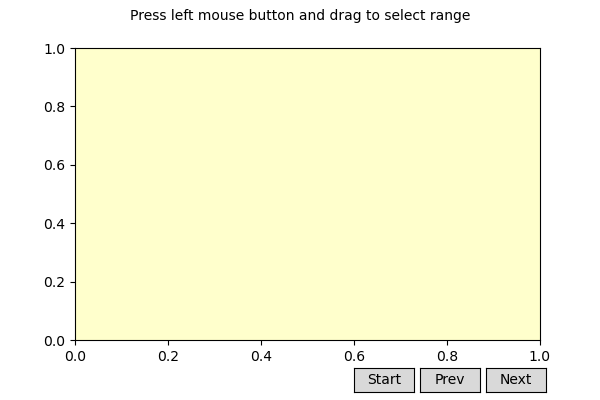

In [6]:
a=LinReg(data_NADH1)

In [7]:
slopes1 = a.make_summary()
slopes1.head()

,rate
Sample_A1,-0.010981
Sample_A2,-0.010981
Sample_A3,-0.010137
Sample_B1,-0.008572
Sample_B2,-0.008199


In [12]:
slopes1

,rate
Sample_A1,-0.010981
Sample_A2,-0.010981
Sample_A3,-0.010137
Sample_B1,-0.008572
Sample_B2,-0.008199
Sample_B3,-0.010407
Sample_C1,-0.007903
Sample_C2,-0.007742
Sample_C3,-0.008949
Sample_D1,-0.006540


In [13]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [14]:
slopes1 = slopes1 / El # umol/ml/min (mM/min)
slopes1 = slopes1 / (protein/V) # umol/min/mg prot
exp1rates = -slopes1

In [15]:
exp1rates

,rate
Sample_A1,0.031542
Sample_A2,0.031542
Sample_A3,0.029118
Sample_B1,0.024622
Sample_B2,0.023552
Sample_B3,0.029893
Sample_C1,0.022700
Sample_C2,0.022237
Sample_C3,0.025704
Sample_D1,0.018787


In [16]:
writer = pandas.ExcelWriter('output_forward1.xlsx')
exp1rates.to_excel(writer, sheet_name='exp1')
writer.save()

# Experiment 2: 0.41mM NADH

In [17]:
data_NADH2 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad2.xlsx")
#A view of the data
data_NADH2.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.774830,0.773278,0.776055,0.776365,0.783495,0.842505,0.780089,0.702865,0.711199,...,0.675809,0.606518,0.633295,0.680884,0.656587,0.599725,0.615364,0.600787,0.613299,0.687737
1,0.079900,0.772702,0.771802,0.773416,0.776984,0.767868,0.820819,0.769009,0.705161,0.706967,...,0.673716,0.603064,0.634201,0.688407,0.663044,0.598558,0.611766,0.595087,0.615552,0.668199
2,0.163217,0.769515,0.778288,0.775928,0.770792,0.757649,0.832610,0.755658,0.701794,0.713218,...,0.671591,0.604521,0.628819,0.663933,0.655185,0.599563,0.609242,0.591813,0.610865,0.667213
3,0.246483,0.770476,0.777349,0.785444,0.772609,0.797742,0.817045,0.769344,0.697603,0.707207,...,0.671306,0.601307,0.625719,0.662217,0.645351,0.598358,0.606407,0.593243,0.608513,0.664005
4,0.329550,0.772048,0.777139,0.785058,0.776148,0.798725,0.803565,0.753517,0.710976,0.706909,...,0.668736,0.603592,0.631757,0.661499,0.645942,0.602042,0.606262,0.593776,0.609603,0.656785


In [18]:

data_NADH2.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH2.columns]
data_NADH2.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.774830,0.773278,0.776055,0.776365,0.783495,0.842505,0.780089,0.702865,0.711199,...,0.675809,0.606518,0.633295,0.680884,0.656587,0.599725,0.615364,0.600787,0.613299,0.687737
1,0.079900,0.772702,0.771802,0.773416,0.776984,0.767868,0.820819,0.769009,0.705161,0.706967,...,0.673716,0.603064,0.634201,0.688407,0.663044,0.598558,0.611766,0.595087,0.615552,0.668199
2,0.163217,0.769515,0.778288,0.775928,0.770792,0.757649,0.832610,0.755658,0.701794,0.713218,...,0.671591,0.604521,0.628819,0.663933,0.655185,0.599563,0.609242,0.591813,0.610865,0.667213
3,0.246483,0.770476,0.777349,0.785444,0.772609,0.797742,0.817045,0.769344,0.697603,0.707207,...,0.671306,0.601307,0.625719,0.662217,0.645351,0.598358,0.606407,0.593243,0.608513,0.664005
4,0.329550,0.772048,0.777139,0.785058,0.776148,0.798725,0.803565,0.753517,0.710976,0.706909,...,0.668736,0.603592,0.631757,0.661499,0.645942,0.602042,0.606262,0.593776,0.609603,0.656785


In [19]:
samples = [s for s in data_NADH2.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH2.index,
    index=(0,40),
    description='Time [min]',
)

In [20]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
           

C:\Users\Francel\AppData\Local\Temp\ipykernel_20660\3657682931.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_20660\3657682931.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


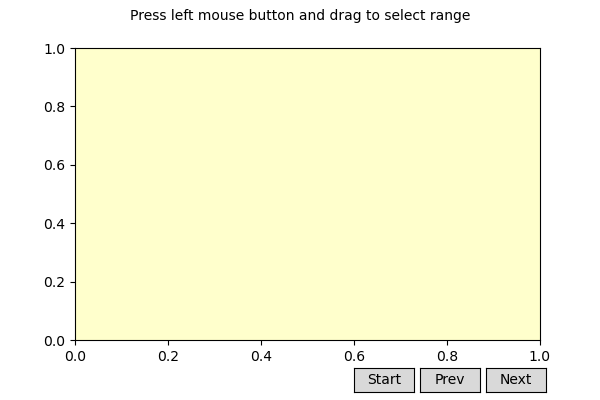

In [21]:
a=LinReg(data_NADH2)

In [27]:
slopes2 = a.make_summary()
slopes2.head()

,rate
Sample_A1,-0.006954
Sample_A2,-0.009589
Sample_A3,-0.008758
Sample_B1,-0.006367
Sample_B2,-0.006790


In [28]:
slopes2

,rate
Sample_A1,-0.006954
Sample_A2,-0.009589
Sample_A3,-0.008758
Sample_B1,-0.006367
Sample_B2,-0.006790
Sample_B3,-0.007247
Sample_C1,-0.006263
Sample_C2,-0.007782
Sample_C3,-0.006902
Sample_D1,-0.005142


In [55]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [29]:
slopes2 = slopes2 / El # umol/ml/min (mM/min)
slopes2 = slopes2 / (protein/V) # umol/min/mg prot
#slopes2_pre_complete = slopes2 / (-1) #sign change if needed 
exp2rates = -slopes2

In [30]:
exp2rates

,rate
Sample_A1,0.019974
Sample_A2,0.027543
Sample_A3,0.025156
Sample_B1,0.018288
Sample_B2,0.019504
Sample_B3,0.020815
Sample_C1,0.017991
Sample_C2,0.022353
Sample_C3,0.019826
Sample_D1,0.014769


In [31]:
writer = pandas.ExcelWriter('output_forward2.xlsx')
exp2rates.to_excel(writer, sheet_name='exp2')
writer.save()

# Experiment 3: 0.33mM NADH

In [62]:
data_NADH3 = pandas.read_excel(r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad3.xlsx")
#A view of the data
data_NADH3.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.711038,0.706014,0.722082,0.693868,0.695789,0.771638,0.708984,0.632417,0.660180,...,0.596646,0.568240,0.579977,0.609627,0.602094,0.538809,0.566232,0.542563,0.551008,0.601478
1,0.077817,0.709455,0.703942,0.722762,0.688883,0.694706,0.747630,0.704939,0.627386,0.657660,...,0.596788,0.572751,0.574200,0.595570,0.615414,0.535284,0.558906,0.543120,0.557852,0.609842
2,0.161217,0.707116,0.705099,0.727515,0.689781,0.695050,0.740732,0.705796,0.634206,0.658026,...,0.596822,0.571370,0.577784,0.597246,0.588601,0.535099,0.564273,0.541208,0.550206,0.610998
3,0.244483,0.707256,0.703295,0.723781,0.695464,0.693049,0.724079,0.705958,0.627121,0.654802,...,0.595265,0.558786,0.573196,0.575465,0.582902,0.533302,0.567374,0.536229,0.545391,0.574983
4,0.327833,0.706812,0.703223,0.726366,0.691298,0.695557,0.710438,0.701336,0.634607,0.653182,...,0.597583,0.568555,0.580824,0.614970,0.583362,0.533717,0.562247,0.534460,0.550097,0.605471


In [63]:
data_NADH3.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH3.columns]
data_NADH3.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.711038,0.706014,0.722082,0.693868,0.695789,0.771638,0.708984,0.632417,0.660180,...,0.596646,0.568240,0.579977,0.609627,0.602094,0.538809,0.566232,0.542563,0.551008,0.601478
1,0.077817,0.709455,0.703942,0.722762,0.688883,0.694706,0.747630,0.704939,0.627386,0.657660,...,0.596788,0.572751,0.574200,0.595570,0.615414,0.535284,0.558906,0.543120,0.557852,0.609842
2,0.161217,0.707116,0.705099,0.727515,0.689781,0.695050,0.740732,0.705796,0.634206,0.658026,...,0.596822,0.571370,0.577784,0.597246,0.588601,0.535099,0.564273,0.541208,0.550206,0.610998
3,0.244483,0.707256,0.703295,0.723781,0.695464,0.693049,0.724079,0.705958,0.627121,0.654802,...,0.595265,0.558786,0.573196,0.575465,0.582902,0.533302,0.567374,0.536229,0.545391,0.574983
4,0.327833,0.706812,0.703223,0.726366,0.691298,0.695557,0.710438,0.701336,0.634607,0.653182,...,0.597583,0.568555,0.580824,0.614970,0.583362,0.533717,0.562247,0.534460,0.550097,0.605471


In [64]:
samples = [s for s in data_NADH3.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH3.index,
    index=(0,40),
    description='Time [min]',
)

In [65]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


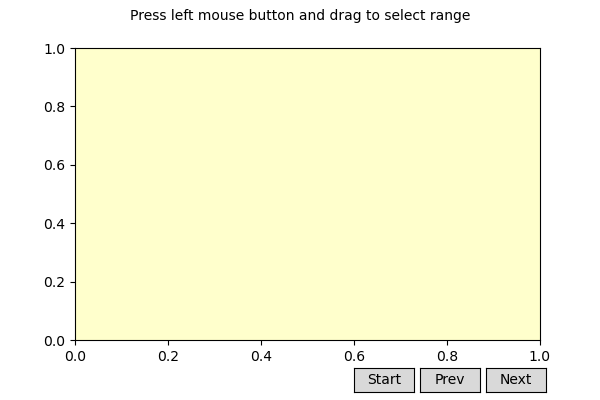

In [66]:
a=LinReg(data_NADH3)

In [67]:
slopes3 = a.make_summary()
slopes3.head()

,rate
Sample_A4,-0.006091
Sample_A5,-0.006889
Sample_A6,-0.006234
Sample_B4,-0.005845
Sample_B5,-0.005753


In [68]:
slopes3

,rate
Sample_A4,-0.006091
Sample_A5,-0.006889
Sample_A6,-0.006234
Sample_B4,-0.005845
Sample_B5,-0.005753
Sample_B6,-0.006139
Sample_C4,-0.005094
Sample_C5,-0.004874
Sample_C6,-0.004539
Sample_D4,-0.005099


In [75]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [76]:
slopes3 = slopes3 / El # umol/ml/min (mM/min)
slopes3 = slopes3 / (protein/V) # umol/min/mg prot
#slopes3_pre_complete = slopes3 / (-1) #sign change if needed 
exp3rates = -slopes3

In [82]:
writer = pandas.ExcelWriter('output_forward3.xlsx')
exp3rates.to_excel(writer, sheet_name='exp3')
writer.save()

# Experiment 4: 0.083mM NADH (at Km)

In [83]:
data_NADH4 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad4.xlsx")
#A view of the data
data_NADH4.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.448517,0.514535,0.494695,0.423929,0.413102,0.414663,0.422704,0.361018,0.360990,...,0.335561,0.272535,0.289879,0.347141,0.317449,0.277741,0.286227,0.299581,0.274515,0.330511
1,0.077683,0.463899,0.517850,0.487060,0.422345,0.414231,0.427065,0.412787,0.363958,0.364825,...,0.321008,0.279183,0.292056,0.337724,0.302864,0.277205,0.282941,0.311011,0.272494,0.335482
2,0.161167,0.464689,0.508642,0.479204,0.419921,0.403487,0.442126,0.378846,0.364160,0.367317,...,0.329585,0.278791,0.295915,0.354591,0.302822,0.276583,0.288139,0.304964,0.277300,0.326963
3,0.244483,0.453489,0.509076,0.481056,0.416070,0.399803,0.447531,0.387622,0.354241,0.370927,...,0.322598,0.271662,0.287624,0.333060,0.295717,0.274583,0.292845,0.303092,0.271259,0.317186
4,0.327900,0.454270,0.516552,0.477747,0.417518,0.396846,0.422373,0.387695,0.358147,0.366027,...,0.322580,0.273410,0.292679,0.350152,0.290304,0.274582,0.289794,0.311115,0.275167,0.304380


In [84]:
data_NADH4.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH4.columns]
data_NADH4.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.448517,0.514535,0.494695,0.423929,0.413102,0.414663,0.422704,0.361018,0.360990,...,0.335561,0.272535,0.289879,0.347141,0.317449,0.277741,0.286227,0.299581,0.274515,0.330511
1,0.077683,0.463899,0.517850,0.487060,0.422345,0.414231,0.427065,0.412787,0.363958,0.364825,...,0.321008,0.279183,0.292056,0.337724,0.302864,0.277205,0.282941,0.311011,0.272494,0.335482
2,0.161167,0.464689,0.508642,0.479204,0.419921,0.403487,0.442126,0.378846,0.364160,0.367317,...,0.329585,0.278791,0.295915,0.354591,0.302822,0.276583,0.288139,0.304964,0.277300,0.326963
3,0.244483,0.453489,0.509076,0.481056,0.416070,0.399803,0.447531,0.387622,0.354241,0.370927,...,0.322598,0.271662,0.287624,0.333060,0.295717,0.274583,0.292845,0.303092,0.271259,0.317186
4,0.327900,0.454270,0.516552,0.477747,0.417518,0.396846,0.422373,0.387695,0.358147,0.366027,...,0.322580,0.273410,0.292679,0.350152,0.290304,0.274582,0.289794,0.311115,0.275167,0.304380


In [85]:
samples = [s for s in data_NADH4.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH4.index,
    index=(0,40),
    description='Time [min]')

In [86]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


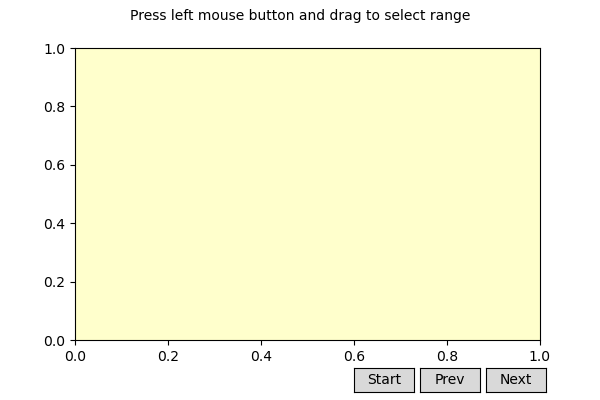

In [87]:
a=LinReg(data_NADH4)

In [88]:
slopes4 = a.make_summary()
slopes4.head()

,rate
Sample_A4,-0.006640
Sample_A5,-0.005846
Sample_A6,-0.005577
Sample_B4,-0.005277
Sample_B5,-0.004967


In [89]:
slopes4

,rate
Sample_A4,-0.006640
Sample_A5,-0.005846
Sample_A6,-0.005577
Sample_B4,-0.005277
Sample_B5,-0.004967
Sample_B6,-0.004937
Sample_C4,-0.004984
Sample_C5,-0.003785
Sample_C6,-0.004727
Sample_D4,-0.004017


In [96]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [97]:
slopes4 = slopes4 / El # umol/ml/min (mM/min)
slopes4 = slopes4 / (protein/V) # umol/min/mg prot
#frame_pre_complete = frame / (-1) #sign change if needed 
exp4rates = -slopes4

In [102]:
writer = pandas.ExcelWriter('output2virexp4.xlsx')
exp4rates.to_excel(writer, sheet_name='exp4')
writer.save()

# Experiment 5: 0.067mM NADH

In [103]:
data_NADH5 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad5.xlsx")
#A view of the data
data_NADH5.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.452727,0.456005,0.456983,0.443619,0.440725,0.442507,0.414568,0.376821,0.391120,...,0.343922,0.303403,0.312087,0.302865,0.285287,0.266372,0.318631,0.297759,0.300341,0.283460
1,0.075967,0.455869,0.458951,0.457689,0.449883,0.442403,0.446697,0.422889,0.373231,0.396427,...,0.342654,0.302575,0.313332,0.300193,0.284221,0.267764,0.310724,0.295908,0.303374,0.280608
2,0.158983,0.469818,0.456596,0.454424,0.439676,0.443901,0.462087,0.400979,0.378880,0.389178,...,0.340720,0.302171,0.320816,0.299636,0.285341,0.262241,0.316206,0.291586,0.308125,0.282341
3,0.242433,0.464372,0.453653,0.454834,0.444565,0.441526,0.471149,0.423941,0.369677,0.388299,...,0.336589,0.301087,0.318841,0.298361,0.285136,0.266321,0.307322,0.291235,0.303891,0.282407
4,0.325917,0.470564,0.453905,0.457415,0.450774,0.440143,0.466759,0.404452,0.368408,0.397343,...,0.340604,0.301393,0.319730,0.298465,0.283106,0.260782,0.313618,0.290297,0.299403,0.278063


In [104]:
data_NADH5.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH5.columns]
data_NADH5.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.452727,0.456005,0.456983,0.443619,0.440725,0.442507,0.414568,0.376821,0.391120,...,0.343922,0.303403,0.312087,0.302865,0.285287,0.266372,0.318631,0.297759,0.300341,0.283460
1,0.075967,0.455869,0.458951,0.457689,0.449883,0.442403,0.446697,0.422889,0.373231,0.396427,...,0.342654,0.302575,0.313332,0.300193,0.284221,0.267764,0.310724,0.295908,0.303374,0.280608
2,0.158983,0.469818,0.456596,0.454424,0.439676,0.443901,0.462087,0.400979,0.378880,0.389178,...,0.340720,0.302171,0.320816,0.299636,0.285341,0.262241,0.316206,0.291586,0.308125,0.282341
3,0.242433,0.464372,0.453653,0.454834,0.444565,0.441526,0.471149,0.423941,0.369677,0.388299,...,0.336589,0.301087,0.318841,0.298361,0.285136,0.266321,0.307322,0.291235,0.303891,0.282407
4,0.325917,0.470564,0.453905,0.457415,0.450774,0.440143,0.466759,0.404452,0.368408,0.397343,...,0.340604,0.301393,0.319730,0.298465,0.283106,0.260782,0.313618,0.290297,0.299403,0.278063


In [105]:
samples = [s for s in data_NADH5.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH5.index,
    index=(0,40),
    description='Time [min]',
)

In [106]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


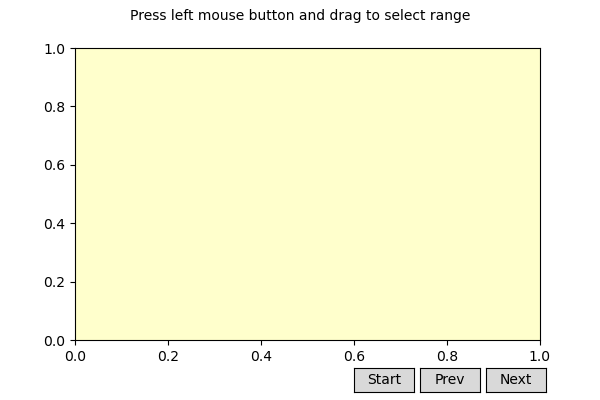

In [107]:
a=LinReg(data_NADH5)

In [108]:
slopes5 = a.make_summary()
slopes5.head()

,rate
Sample_A7,-0.005684
Sample_A8,-0.004718
Sample_A9,-0.006028
Sample_B7,-0.004947
Sample_B8,-0.004512


In [109]:
slopes5

,rate
Sample_A7,-0.005684
Sample_A8,-0.004718
Sample_A9,-0.006028
Sample_B7,-0.004947
Sample_B8,-0.004512
Sample_B9,-0.004805
Sample_C7,-0.004326
Sample_C8,-0.003773
Sample_C9,-0.003984
Sample_D7,-0.004002


In [116]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [117]:
slopes5 = slopes5 / El # umol/ml/min (mM/min)
slopes5 = slopes5 / (protein/V) # umol/min/mg prot
#slopes5_pre_complete = slopes5 / (-1) #sign change if needed 
exp5rates = -slopes5

In [121]:
writer = pandas.ExcelWriter('output3virexp5.xlsx')
exp5rates.to_excel(writer, sheet_name='exp5')
writer.save()

# Experiment 6: 0.05mM NADH

In [122]:
data_NADH6 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad6.xlsx")
#A view of the data
data_NADH6.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.420527,0.420993,0.428089,0.408777,0.404179,0.403618,0.355994,0.353102,0.358834,...,0.311578,0.263150,0.264169,0.253993,0.257844,0.248850,0.253592,0.246221,0.258275,0.239446
1,0.075767,0.422482,0.419552,0.430932,0.411746,0.399129,0.397641,0.333965,0.348969,0.357271,...,0.307137,0.263995,0.270706,0.253475,0.287753,0.251874,0.256679,0.247319,0.250823,0.236626
2,0.159200,0.422738,0.415485,0.423731,0.402569,0.401625,0.442451,0.340193,0.354117,0.359111,...,0.304599,0.261590,0.265642,0.251504,0.255698,0.244143,0.253367,0.245167,0.254600,0.237551
3,0.242400,0.431058,0.416131,0.424991,0.401043,0.402125,0.440548,0.341181,0.345734,0.359277,...,0.301951,0.260206,0.264974,0.251914,0.249103,0.243513,0.253024,0.245669,0.257276,0.234903
4,0.325750,0.431446,0.415259,0.425639,0.411683,0.404737,0.446808,0.337236,0.353056,0.368384,...,0.299258,0.261328,0.267393,0.252472,0.268374,0.249341,0.252613,0.246719,0.250085,0.234672


In [123]:
data_NADH6.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH6.columns]
data_NADH6.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.420527,0.420993,0.428089,0.408777,0.404179,0.403618,0.355994,0.353102,0.358834,...,0.311578,0.263150,0.264169,0.253993,0.257844,0.248850,0.253592,0.246221,0.258275,0.239446
1,0.075767,0.422482,0.419552,0.430932,0.411746,0.399129,0.397641,0.333965,0.348969,0.357271,...,0.307137,0.263995,0.270706,0.253475,0.287753,0.251874,0.256679,0.247319,0.250823,0.236626
2,0.159200,0.422738,0.415485,0.423731,0.402569,0.401625,0.442451,0.340193,0.354117,0.359111,...,0.304599,0.261590,0.265642,0.251504,0.255698,0.244143,0.253367,0.245167,0.254600,0.237551
3,0.242400,0.431058,0.416131,0.424991,0.401043,0.402125,0.440548,0.341181,0.345734,0.359277,...,0.301951,0.260206,0.264974,0.251914,0.249103,0.243513,0.253024,0.245669,0.257276,0.234903
4,0.325750,0.431446,0.415259,0.425639,0.411683,0.404737,0.446808,0.337236,0.353056,0.368384,...,0.299258,0.261328,0.267393,0.252472,0.268374,0.249341,0.252613,0.246719,0.250085,0.234672


In [124]:
samples = [s for s in data_NADH6.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH6.index,
    index=(0,40),
    description='Time [min]',
)

In [125]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


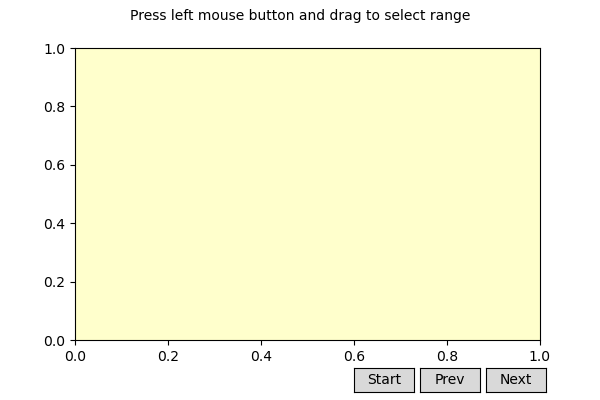

In [129]:
a=LinReg(data_NADH6)

In [130]:
slopes6 = a.make_summary()
slopes6.head()

,rate
Sample_A7,-0.003625
Sample_A8,-0.003944
Sample_A9,-0.003827
Sample_B7,-0.003145
Sample_B8,-0.003462


In [131]:
slopes6

,rate
Sample_A7,-0.003625
Sample_A8,-0.003944
Sample_A9,-0.003827
Sample_B7,-0.003145
Sample_B8,-0.003462
Sample_B9,-0.003891
Sample_C7,-0.003326
Sample_C8,-0.002993
Sample_C9,-0.002797
Sample_D7,-0.002874


In [138]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [139]:
slopes6 = slopes6 / El # umol/ml/min (mM/min)
slopes6 = slopes6 / (protein/V) # umol/min/mg prot
#slopes6_pre_complete = slopes6 / (-1) #sign change if needed 
exp6rates = -slopes6

In [143]:
writer = pandas.ExcelWriter('output4virexp6.xlsx')
exp6rates.to_excel(writer, sheet_name='exp6')
writer.save()

# Experiment 7: 0.042mM NADH

In [162]:
data_NADH7 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - Tecan (nuwe pH = 5.5)\nad7.xlsx")
#A view of the data
data_NADH7.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.427939,0.427222,0.424720,0.435611,0.414307,0.406916,0.333992,0.352465,0.356240,...,0.321254,0.280412,0.290676,0.283480,0.264159,0.264917,0.278088,0.261588,0.268735,0.260231
1,0.075967,0.428805,0.426972,0.421371,0.435815,0.411752,0.403722,0.331124,0.354247,0.357642,...,0.321199,0.280850,0.295182,0.284136,0.266152,0.266229,0.276514,0.259840,0.266345,0.264594
2,0.159283,0.427910,0.427780,0.421659,0.439981,0.410800,0.406029,0.329785,0.352094,0.356233,...,0.320322,0.279481,0.293938,0.281858,0.265625,0.268045,0.277708,0.259833,0.265845,0.262155
3,0.242600,0.425717,0.429447,0.420861,0.446138,0.409840,0.403044,0.328455,0.355882,0.355573,...,0.321488,0.277395,0.288185,0.281156,0.264824,0.267642,0.280457,0.254537,0.268041,0.265255
4,0.325983,0.424012,0.429142,0.424254,0.450859,0.416815,0.404599,0.327378,0.353289,0.356501,...,0.320220,0.278556,0.294285,0.280900,0.260705,0.262642,0.277098,0.254711,0.267228,0.262108


In [163]:
data_NADH7.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH7.columns]
data_NADH7.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.427939,0.427222,0.424720,0.435611,0.414307,0.406916,0.333992,0.352465,0.356240,...,0.321254,0.280412,0.290676,0.283480,0.264159,0.264917,0.278088,0.261588,0.268735,0.260231
1,0.075967,0.428805,0.426972,0.421371,0.435815,0.411752,0.403722,0.331124,0.354247,0.357642,...,0.321199,0.280850,0.295182,0.284136,0.266152,0.266229,0.276514,0.259840,0.266345,0.264594
2,0.159283,0.427910,0.427780,0.421659,0.439981,0.410800,0.406029,0.329785,0.352094,0.356233,...,0.320322,0.279481,0.293938,0.281858,0.265625,0.268045,0.277708,0.259833,0.265845,0.262155
3,0.242600,0.425717,0.429447,0.420861,0.446138,0.409840,0.403044,0.328455,0.355882,0.355573,...,0.321488,0.277395,0.288185,0.281156,0.264824,0.267642,0.280457,0.254537,0.268041,0.265255
4,0.325983,0.424012,0.429142,0.424254,0.450859,0.416815,0.404599,0.327378,0.353289,0.356501,...,0.320220,0.278556,0.294285,0.280900,0.260705,0.262642,0.277098,0.254711,0.267228,0.262108


In [164]:
samples = [s for s in data_NADH7.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH7.index,
    index=(0,40),
    description='Time [min]',
)

In [165]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_12012\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


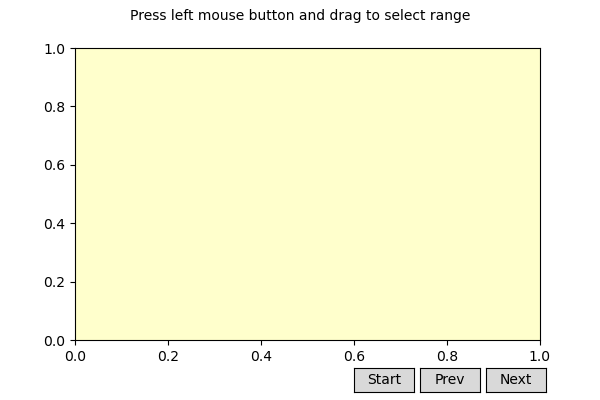

In [166]:
a=LinReg(data_NADH7)

In [167]:
slopes7 = a.make_summary()
slopes7.head()

,rate
Sample_A1,-0.002978
Sample_A2,-0.003005
Sample_A3,-0.002193
Sample_B1,-0.002238
Sample_B2,-0.002158


In [168]:
slopes7

,rate
Sample_A1,-0.002978
Sample_A2,-0.003005
Sample_A3,-0.002193
Sample_B1,-0.002238
Sample_B2,-0.002158
Sample_B3,-0.001705
Sample_C1,-0.001744
Sample_C2,-0.001466
Sample_C3,-0.001772
Sample_D1,-0.001287


In [175]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [176]:
slopes7 = slopes7 / El # umol/ml/min (mM/min)
slopes7 = slopes7 / (protein/V) # umol/min/mg prot
#slopes7_pre_complete = slopes7 / (-1) #sign change if needed 
exp7rates = -slopes7

In [179]:
writer = pandas.ExcelWriter('output6for exp7.xlsx')
exp7rates.to_excel(writer, sheet_name='exp7')
writer.save()